In [1]:
import deps

## Path Planning
### 1. Problem setup

The solver requires an environment and an agent(denominated explorer). The agent determines the cost function definitions.

In [2]:
from pextant.explorers import Astronaut
from pextant.EnvironmentalModel import load_legacy

To illustrate the use, our example will use the Apollo 14 map. Maximum slope is set to 15 degrees which is reasonable for astronaut traverses. To speed up the solver for later we need to pass in the argument cached=True to the loadSubSection method. This will carry out some preprocessing that will speed up solution time later on.

In [3]:
apollo14_gridmesh = load_legacy("Apollo14.txt")
apollo14_model = apollo14_gridmesh.loadSubSection(maxSlope=10, cached=True)
agent = Astronaut(80)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from matplotlib_scalebar.scalebar import ScaleBar
from pextant.viz.utils import hillshade
from pextant.lib.geoshapely import GeoPoint, GeoPolygon

In [5]:
start = GeoPoint(apollo14_model.ROW_COL, 750, 100)
goal = GeoPoint(apollo14_model.ROW_COL, 650, 900)
waypoints = GeoPolygon([start, goal])

We will choose for start the location of the Lunar lander, and for goal the border of the crater rim, this is to very roughly approximate the actual EVA - which has several intermediate points included.

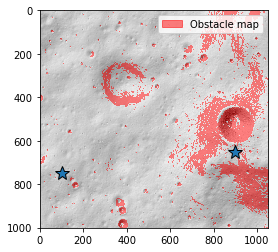

In [6]:
hillshade(apollo14_model,1)
plt.imshow(apollo14_model.obstacle_mask(), alpha=0.5, cmap='bwr_r')
plt.plot(*waypoints.to(apollo14_model.COL_ROW), \
         linestyle='None', marker='*', markeredgecolor="k", markersize=15)
red_patch = mpatches.Patch(color='red', alpha=0.5, label='Obstacle map')
plt.legend(handles=[red_patch])
# plt.gca().add_artist(ScaleBar(apollo14_model.resolution, location=4))
plt.show()

### 2. Solver setup

In [7]:
from pextant.solvers.astarMesh import astarSolver

SEXTANT had a slightly unefficient implementation, so this was just changed at the tailgate of the project. It implements a slightly modified version of networkx's astar solver.

In [8]:
pathfinder = astarSolver(apollo14_model, agent, inhouse=False)

In [9]:
%%time 
out,_,_ = pathfinder.solvemultipoint(waypoints)

Wall time: 1min 6s


Next we can overlay the solution on the map visualization:

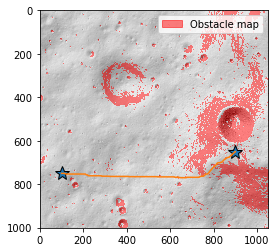

In [10]:
hillshade(apollo14_model,1)
plt.imshow(apollo14_model.obstacle_mask(), alpha=0.5, cmap='bwr_r')
plt.plot(*waypoints.to(apollo14_model.COL_ROW), \
         linestyle='None', marker='*', markeredgecolor="k", markersize=15)
plt.plot(*out.coordinates().to(apollo14_model.COL_ROW))
plt.legend(handles=[red_patch])
# plt.gca().add_artist(ScaleBar(apollo14_model.resolution, location=4))
plt.show()

### 3. Post processing of a path

In [11]:
from pextant.explorers import TraversePath

In [12]:
traverse = TraversePath.frommap(out.coordinates(), apollo14_model)

In [13]:
_, _, dr = agent.path_dl_slopes(traverse)
energies, v = agent.path_energy_expenditure(traverse)

In [14]:
import numpy as np

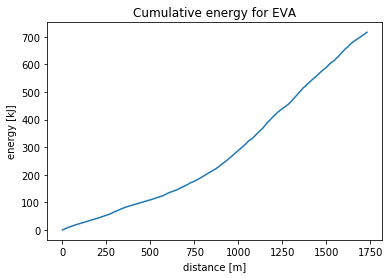

In [15]:
plt.plot(np.cumsum(dr), np.cumsum(energies)/1000.)
plt.xlabel('distance [m]')
plt.ylabel('energy [kJ]')
plt.title('Cumulative energy for EVA')
plt.show()